# Image-to-Image MNIST example

In the last notebook we looked at the creation of handwritten digits conditional on a label. Now where looking at a case where we want to generate images condtional on already existing images. This might be used to translate images with a summer scenery into a winter scenery. Or it might be used to translate pictures of horses into pictures of zebras. In this notebook we will try to do something far more simple. Rotate images of handwritten digits by 90 degrees.

First import the usual libraries:

In [2]:
import os
import torch
import pickle

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

import vegans.utils.loading as loading
from vegans.GAN import ConditionalWassersteinGAN, ConditionalWassersteinGANGP
from vegans.utils.utils import plot_losses, plot_images, get_input_dim

Check if your machine has an available GPU for usage.

In [3]:
print('Cuda is available: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda is available: False


/home/thomas/miniconda3/envs/pytorch38/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378062065/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Now download the mnist dataset and set the parameters below (To get exactly the same format as in this tutorial download from [here](https://github.com/tneuer/GAN-pytorch/tree/main/data/mnist), but of course you can load it from anywhere you want):

In [4]:
# This directory will contain the data
datapath = "./data"

# Hidden layer channels for generator / critic
ngf = 8
ncf = 4

# Padding for mnist images (28x28) -> (32x32)
pad = 2

Now load and preprocess the data:
- The images are saved in gray scale from 0-255, so we scale it to 0-1. Then we can use a Sigmoid as the last layer of the generator.
- The original image shape is (28, 28) but when working with convolutional layers it is often beneficial to have a power of two. Therefore we pad two empty rows and columns to every image.
- Finally we reshape the images because we need the images in the shape of (nr_channels, nr_heiht_pixels, nr_width_pixels). In out case this results in [1, 32, 32]
- Rotate the images by 90 degrees to get our target images.

In [5]:
""" Create dataset
"""
X_train, y_train, X_test, y_test = loading.load_data(datapath, which="mnist", download=True)
    
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

y_train = np.array([np.rot90(image) for image in X_train]).reshape(-1, 1, 32, 32)
X_train = X_train.reshape(-1, 1, 32, 32)
y_test = np.array([np.rot90(image) for image in X_test]).reshape(-1, 1, 32, 32)
X_test = X_test.reshape(-1, 1, 32, 32)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60000, 1, 32, 32) (10000, 1, 32, 32) (60000, 1, 32, 32) (10000, 1, 32, 32)


Now we plot the handwritten digits, this time using the labels because we anyway need them later for this supervised algortihm.

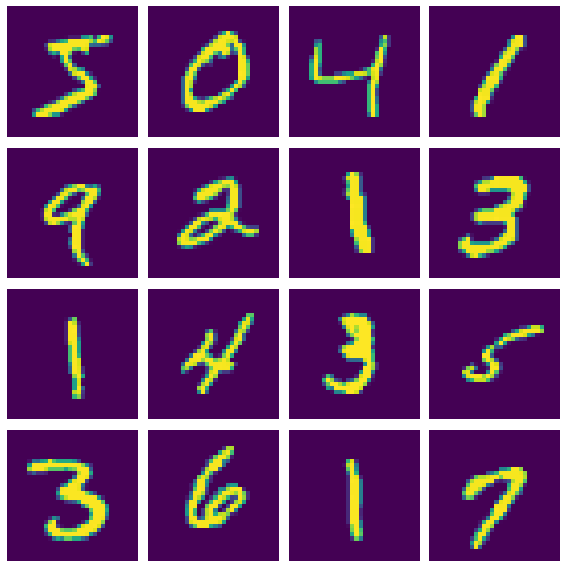

----------------------------------------------------------------------


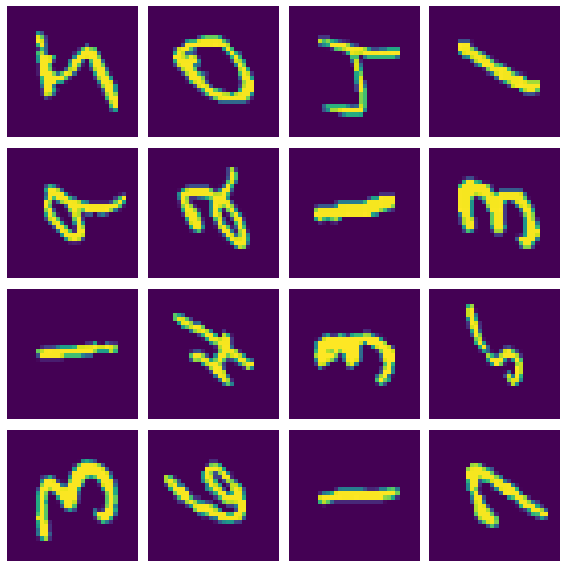

In [6]:
fig, axs = plot_images(images=X_train.reshape(-1, 32, 32), n=16)
print("-"*70)
fig, axs = plot_images(images=y_train.reshape(-1, 32, 32), n=16)

We now define all the different input sizes for the discriminator and generator. Note that internally the images X_train are concatenated with the labels before passing them to the discriminator / critic. The labels are also concatenated with the noise so that the generator as well as the adversary can learn to differentiate between images of different digits. To calculate the number of input channels / features we can use a utility functiion called `get_input_dim(dim1, dim2)`. Note that now in our case the random dimensions are not actually that important because we don't really want random variations of the same input image in this case.

In [6]:
x_dim = X_train.shape[1:]
y_dim = y_train.shape[1:]
z_dim = 4

print("x_dim:", x_dim, "y_dim:", y_dim, "z_dim:", z_dim)
adv_in_dim = get_input_dim(dim1=x_dim, dim2=y_dim)
gen_in_dim = get_input_dim(dim1=z_dim, dim2=y_dim)
print("Adv_dim:", adv_in_dim, "Gen_dim:", gen_in_dim)

x_dim: (1, 32, 32) y_dim: (1, 32, 32) z_dim: 4
Adv_dim: [2, 32, 32] Gen_dim: [5, 32, 32]


Note that the `z_dim` get concatenated with the channel axis of the `y_dim`, while `y_dim` gets concatenated with `x_dim`. 

### Definition of Generator and Discriminator / Critic
We'll specify the architecture of the generator and discriminator / critic networks. It's difficult to know which architectures to choose before training. Here we used a architecture which proved to work.

Since we want to train a Wasserstein GAN, the output of the critic should be a real number and not a probability. Therefore we drop the last sigmoid and use the identity function. If you want to switch to a architecture that uses a discriminator switch the `nn.Identity` with `nn.Sigmoid` for the adversary.

For the generator we will define a common architecture which first reduces the dimensions of the image but increases the number of channels and then does the same in reverse. We also concatenate previous layers with later layers. This is called the UNET architecture.

In [7]:
class MyGenerator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.encoding = nn.Sequential(
            nn.Conv2d(in_channels=gen_in_dim[0], out_channels=32, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(0.2),
        )
        self.decoding = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
        )
        self.output = nn.Sigmoid()

    def forward(self, x):
        x = self.encoding(x)
        x = self.decoding(x)
        y_pred = self.output(x)
        return y_pred

class MyAdversary(nn.Module):
    def __init__(self, adv_in_dim):
        super().__init__()
        self.hidden_part = nn.Sequential(
            nn.Conv2d(in_channels=adv_in_dim[0], out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(num_features=128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1),
        )
        self.output = nn.Identity()

    def forward(self, x):
        x = self.hidden_part(x)
        y_pred = self.output(x)
        return y_pred
    
generator = MyGenerator(z_dim)
critic = MyAdversary(x_dim)

### Train our GAN
Build a Wasserstein GAN trainer, using default optimizers (we can also specify our own). To use a different GAN algorithm, just use the corresponding class (e.g., `VanillaGAN` for original GAN).

Here you can specify some optional GAN parameters, such as the latent space dimension `z_dim`, the number of samples to save (`fixed_noise_size`) and the optimizer keyword arguments (`optim_kwargs`). We set `folder=None` so that no folder is created where all results would be stored. Otherwise we could give a path like `folder="TrainedModels/GAN"`. All results (summary, images, loss functions, tensorboard information, models) would be saved in that folder. You can control what should be saved in the `fit` method. This folder will never overwrite an existing folder. If the path already exists a new path of the form `folder=path_{TimeStamp}` is created.

We decrease the learning rate of the critic a little in this case.
For this conditional algorithm we also need to pass in the dimension of the one hot encoded labels.

In [8]:
optim_kwargs = {"Generator": {"lr": 0.0005}, "Adversary": {"lr": 0.0001}}
gan = ConditionalWassersteinGAN(
    generator, critic, z_dim=z_dim, x_dim=x_dim, y_dim=y_dim,
    optim_kwargs=optim_kwargs, fixed_noise_size=20, folder=None
)

In [9]:
gan.summary()

Generator
Input shape:  (5, 32, 32)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]           4,032
         LeakyReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          51,264
       BatchNorm2d-4             [-1, 64, 8, 8]             128
         LeakyReLU-5             [-1, 64, 8, 8]               0
            Conv2d-6            [-1, 128, 4, 4]         204,928
       BatchNorm2d-7            [-1, 128, 4, 4]             256
         LeakyReLU-8            [-1, 128, 4, 4]               0
            Conv2d-9            [-1, 256, 4, 4]         295,168
      BatchNorm2d-10            [-1, 256, 4, 4]             512
        LeakyReLU-11            [-1, 256, 4, 4]               0
  ConvTranspose2d-12            [-1, 128, 8, 8]         524,416
      BatchNorm2d-13            [-1, 128, 8, 8]             256
   

Train the networks by calling the `fit()` method. Here you can specify some parameters for training like `eochs`, `batch_size`, `save_model_every`, `save_images_every`, `print_every`, `enable_tensorboard` and others.

You can interrupt training at any time and still access train stats from within the `gan` object. You can resume training later. Note that we increase the number of steps the critic (adversary) is trained, which is common for Wasserstein GANs but not VanillaGANs so take care when switching out algorithms.

To save the results we can set 4 parameters:
- `print_every`: Indicates how often results should be printed to the console. Can be an integer indicating the number of batches after which it should print something or a string of the form "0.25e" (meaning 4 times per epoch) or "3e" (meaning every third epoch.
- `save_model_every`: Indicates how often the model should be saved (in subdirectory self.folder/models). Can be of the same form as `print_every`.
- `save_images_every`: Indicates how often the loss and sample images should be saved (in subdirectory self.folder/images). Can be of the same form as `print_every`.
- `save_losses every`: Indicates how often the model should be saved in the object itself (in subdirectory self.folder/models). Can be of the same form as `print_every`. These losses are used to create the loss image and the tensorboard information. They can be accessed after training with either `gan.get_losses(by_epoch=False)` or `gan.get_training_results(by_epoch=False)`. Set `by_epoch=True` if you want the losses to be aggregated by epoch instead of batches. 

In [10]:
steps = {"Adversary": 5}
gan.fit(
    X_train, y_train, X_test, y_test, epochs=2, steps=steps,
    print_every="0.25e", save_losses_every=10, enable_tensorboard=False
)

------------------------------------------------------------
EPOCH: 1
------------------------------------------------------------
Step: 468 / 3750 (Epoch: 1 / 2, Batch: 468 / 1875)
------------------------------------------------------------
Generator: -0.004218632355332375
Adversary: -0.0028599940706044436
Adversary_fake: 0.004218632820993662
Adversary_real: -0.009938620962202549
RealFakeRatio: -2.355886697769165


Time left: ~23.653 minutes (Steps remaining: 3282).


Step: 936 / 3750 (Epoch: 1 / 2, Batch: 936 / 1875)
------------------------------------------------------------
Generator: -0.009061884135007858
Adversary: -0.0034170784056186676
Adversary_fake: 0.009061885997653008
Adversary_real: -0.015896042808890343
RealFakeRatio: -1.7541649341583252


Time left: ~21.696 minutes (Steps remaining: 2814).


Step: 1404 / 3750 (Epoch: 1 / 2, Batch: 1404 / 1875)
------------------------------------------------------------
Generator: -0.004371464718133211
Adversary: -0.0018855668604373932

Investigate the results and loss curves.

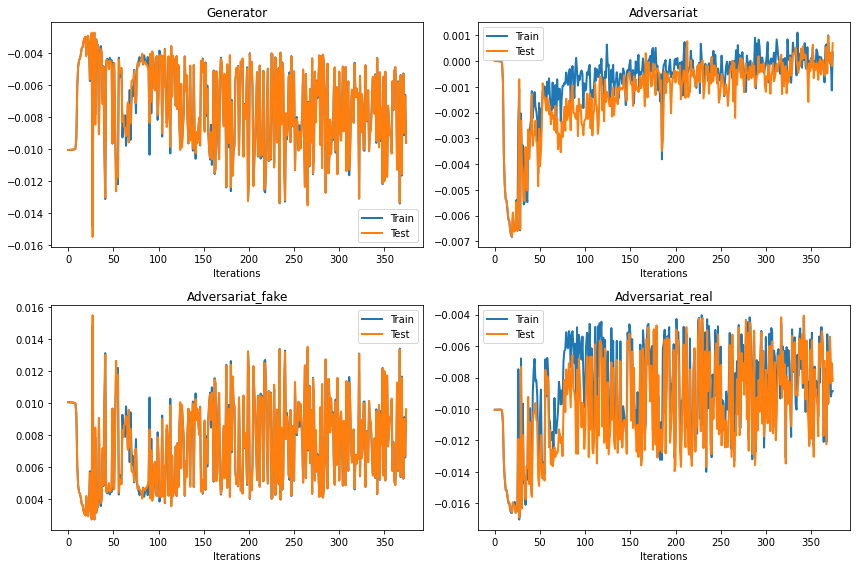

(20, 1, 32, 32)


In [11]:
samples, losses = gan.get_training_results()
fig, axs = plot_losses(losses)
print(samples.shape)

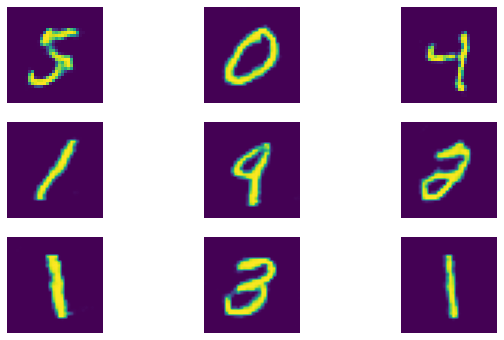

In [12]:
fig, axs = plot_images(samples.reshape(-1, 32, 32), n=9)

Now we want to generate new images and have control over the number of generated images. Note that the `get_training_results` returns as many images as were specified with the `fixed_noise_size` argument in the constructor when creating the GAN.

(10, 1, 32, 32)
Original
--------------


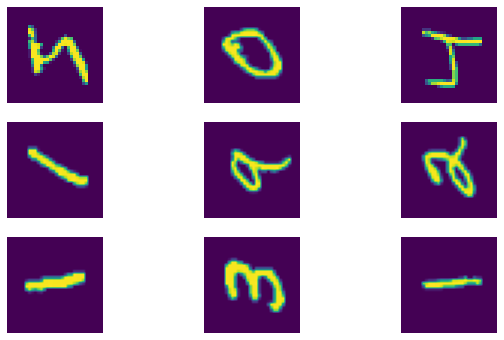

--------------------------------------------------------------------------------
Fake
--------------


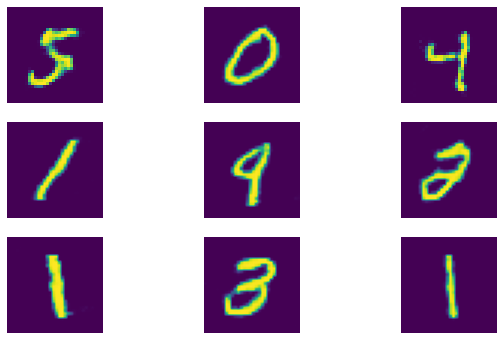

--------------------------------------------------------------------------------
Real
--------------


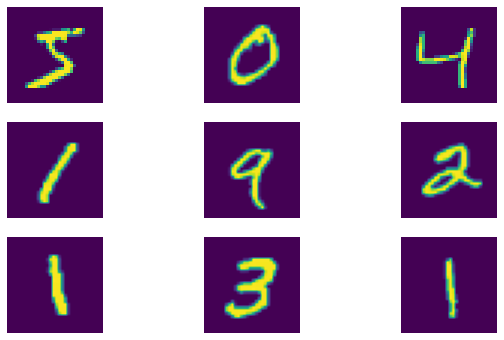

In [19]:
new_samples = gan.generate(y=y_train[:10])
print(new_samples.shape)
print("Original\n--------------")
fig, axs = plot_images(y_train[:10].reshape(-1, 32, 32))
print("-"*80)
print("Fake\n--------------")
fig, axs = plot_images(new_samples.reshape(-1, 32, 32))
print("-"*80)
print("Real\n--------------")
fig, axs = plot_images(X_train[:10].reshape(-1, 32, 32))

The images are basically indistinguishable from the real labels. Let's now try if our generator can also rotate an image twice to check if it really learned a model that can reliably rotate images or if it can just rotate them from left leaning to straight images.

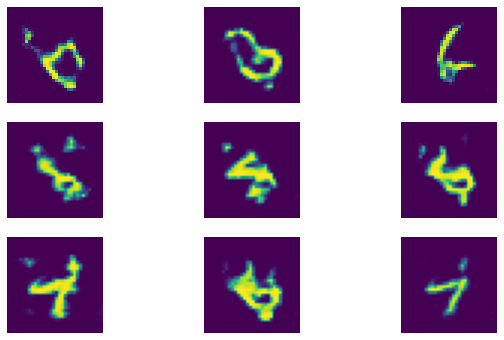

In [21]:
samples_rot180 = gan.generate(y=gan.generate(y=y_train[:10]))
fig, axs = plot_images(samples_rot180.reshape(-1, 32, 32))

Unfortunately these images don't look to good, so our generator can only rotate by 90 degrees.